-------
# Preprocess Crime Dataset
1. Find each suburb total offence count in past two years.
2. Scale the total count by the population.
--------

### Suburb Total Offence Count
1. load crime dataset

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
opt_dir = '../data/raw'

/opt/anaconda3/envs/ads/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Load past two years crime data
crime = pd.read_excel(f"{opt_dir}/external_data/recorded_offences.xlsx", sheet_name="Table 03", nrows=74721)
crime.head(5)

,Year,Year ending,Local Government Area,Postcode,Suburb/Town Name,Offence Division,Offence Subdivision,Offence Subgroup,Offence Count
0,2022,June,Alpine,3691,Dederang,A Crimes against the person,Other crimes against the person,Other crimes against the person,1
1,2022,June,Alpine,3691,Dederang,B Property and deception offences,B40 Theft,B49 Other theft,1
2,2022,June,Alpine,3691,Dederang,D Public order and security offences,D10 Weapons and explosives offences,D11 Firearms offences,1
3,2022,June,Alpine,3691,Dederang,D Public order and security offences,D20 Disorderly and offensive conduct,D22 Drunk and disorderly in public,1
4,2022,June,Alpine,3691,Gundowring,B Property and deception offences,B10 Arson,B11 Cause damage by fire,1


2. Find suburb total offence count

In [3]:
crime = crime[['Suburb/Town Name', 'Offence Count']]
crime_agg = crime.groupby(['Suburb/Town Name'], as_index=False).sum()
crime_agg = crime_agg.rename(columns={'Suburb/Town Name' : 'LOC_NAME'})
crime_agg.head(5)

,LOC_NAME,Offence Count
0,Abbeyard,1
1,Abbotsford,2837
2,Aberfeldie,252
3,Acheron,4
4,Adams Estate,17


### Scale By the Suburb Population.
1. load suburb population data

In [4]:
suburb_shp = gpd.read_file("../data/raw/external_data/vic_localities/vic_localities.shp")
suburb_shp.crs = 'epsg:4326'
suburb_shp = suburb_shp.to_crs("+proj=cea +lat_0=-37.840935 +lon_0=144.946457 +units=km")
suburb = suburb_shp[['LOC_PID', 'LOC_NAME']]
suburb.head(5)

,LOC_PID,LOC_NAME
0,locb0dcb52a6b55,Abbeyard
1,locb9872f35df41,Abbotsford
2,loc8123ed12ea8d,Aberfeldie
3,loc1eb4a229104a,Aberfeldy
4,locb17be87767e1,Acheron


In [5]:
population = pd.read_csv('../data/raw/population_for_suburb.csv', index_col=0)
population.head(5)

,LOC_PID,suburb_population,LOC_NAME,suburb_area,density
0,loc0067a4549ed1,4897.000000,Korumburra,59.867302,81.797573
1,loc00a9769647d7,26158.000000,Kew,10.520939,2486.279947
2,loc00d1503504f1,41928.000000,Glen Waverley,16.838564,2489.998587
3,loc00e6e39d335b,1057.555556,Sailors Falls,9.781214,108.121093
4,loc00f0949ea0ad,39266.294118,Sunbury,132.030479,297.403254


In [6]:
suburb_pop = pd.merge(suburb, population.drop('LOC_NAME', axis=1), on='LOC_PID', how='left')
suburb_pop = suburb_pop.dropna(how='any') # many suburb does not have rental price data, so donot need to analysis.
suburb_pop

,LOC_PID,LOC_NAME,suburb_population,suburb_area,density
1,locb9872f35df41,Abbotsford,10103.000000,1.785957,5656.912320
2,loc8123ed12ea8d,Aberfeldie,1784.330097,1.566635,1138.956765
10,loc0be4112ae167,Aintree,2777.090909,6.778359,409.699591
14,locdeefa3afa7c5,Airport West,8540.000000,3.899229,2190.176309
16,locff0c231b0f12,Albanvale,6300.444444,1.854933,3396.588505
...,...,...,...,...,...
2943,loc6474648a8c40,Yarram,1837.333333,110.911102,16.565820
2945,loc1e3ac2d49583,Yarraville,16651.000000,5.680698,2931.154018
2947,locb0a9c63101c7,Yarrawonga,8597.000000,95.982219,89.568674
2952,locde4077dc8c5f,Yea,1956.000000,177.281564,11.033296


2. Merge the crime data and suburb population

In [16]:
suburb_crime = pd.merge(suburb_pop, crime_agg, on='LOC_NAME', how='left')
suburb_crime['Offence Count'] = suburb_crime['Offence Count'].fillna(suburb_crime['Offence Count'].median())
suburb_crime.head(5)

,LOC_PID,LOC_NAME,suburb_population,suburb_area,density,Offence Count
0,locb9872f35df41,Abbotsford,10103.000000,1.785957,5656.912320,2837.0
1,loc8123ed12ea8d,Aberfeldie,1784.330097,1.566635,1138.956765,252.0
2,loc0be4112ae167,Aintree,2777.090909,6.778359,409.699591,618.0
3,locdeefa3afa7c5,Airport West,8540.000000,3.899229,2190.176309,1580.0
4,locff0c231b0f12,Albanvale,6300.444444,1.854933,3396.588505,836.0


3. Investigate Correlation between population and offence count

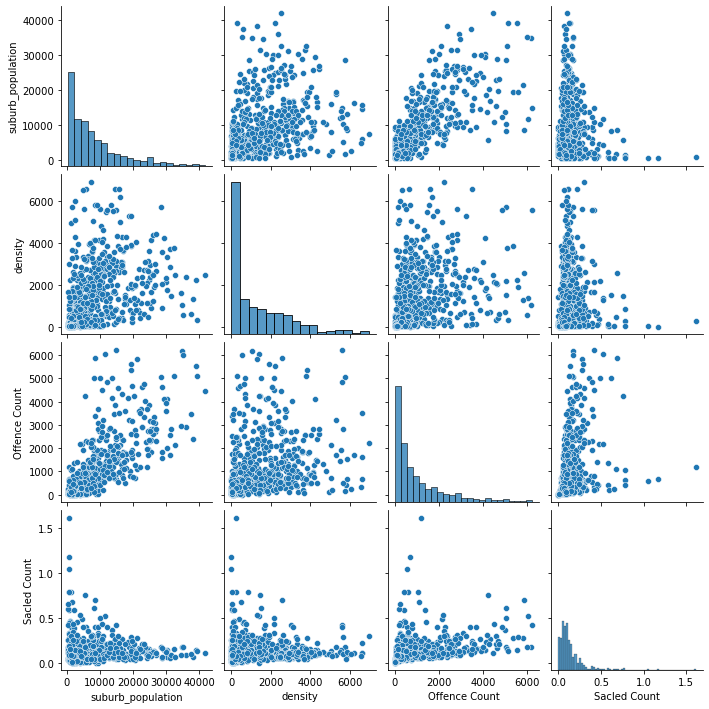

In [17]:
num_var = suburb_crime[['suburb_population', 'density', 'Offence Count']]
THRESHOLD = 3.5
num_var = num_var[(np.abs(stats.zscore(num_var['suburb_population'])) < THRESHOLD )]
num_var = num_var[(np.abs(stats.zscore(num_var['density'])) < THRESHOLD )]
num_var = num_var[(np.abs(stats.zscore(num_var['Offence Count'])) < THRESHOLD )]
num_var['Sacled Count'] = num_var['Offence Count'] / num_var['suburb_population']
sns.pairplot(num_var)
plt.savefig("../plots/suburb_offence_pair.jpeg")

It is found that the Offence Count have strong positive correlation with population. 

However, population is one of feature in analysis, so Offence Count is scaled by suburb population.

After scaled, the correlation reduced.

In [18]:
num_var.corr()

,suburb_population,density,Offence Count,Sacled Count
suburb_population,1.000000,0.424095,0.754804,-0.062264
density,0.424095,1.000000,0.365889,0.024025
Offence Count,0.754804,0.365889,1.000000,0.349873
Sacled Count,-0.062264,0.024025,0.349873,1.000000


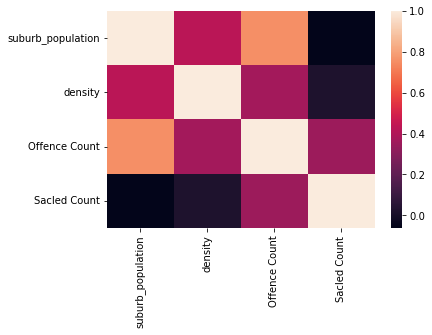

In [23]:
ax = sns.heatmap(num_var.corr())
plt.savefig("../plots/suburb_offence_corr.jpeg", bbox_inches='tight')

In [20]:
suburb_crime['offence_count_scaled'] = suburb_crime['Offence Count'] / suburb_crime['suburb_population']
suburb_crime = suburb_crime[['LOC_PID', 'LOC_NAME', 'offence_count_scaled']]
suburb_crime.head(5)

,LOC_PID,LOC_NAME,offence_count_scaled
0,locb9872f35df41,Abbotsford,0.280808
1,loc8123ed12ea8d,Aberfeldie,0.141229
2,loc0be4112ae167,Aintree,0.222535
3,locdeefa3afa7c5,Airport West,0.185012
4,locff0c231b0f12,Albanvale,0.132689


In [24]:
suburb_crime.to_csv("../data/raw/crime_completed.csv")